I know how to do vector look ups from RAG, but handling the multimodal input is new to me.

I want to try learning how to get multimodal embeddings myself.

In [1]:
# Don't wanna follow the tutorial here, try pulling a multimodal embedding model from openclip

import torch
from PIL import Image
import open_clip
from datasets import load_dataset
from tqdm import tqdm
from chromadb import Client
import numpy as np
from random import randint

/home/zhiyong/.pyenv/versions/3.10.4/envs/multimodal_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

NameError: name 'open_clip' is not defined

In [4]:
# use flickr30k to build image encoding and text encoding, then store them into vector db for look ups. How to track whether it's correct?
from torch.utils.data import DataLoader
dataset = load_dataset('nlphuji/flickr30k')

# Have to load each image individually, no batching
processed_images = []
captions_tokens = []
for sample in tqdm(dataset['test']):
    processed_images.append(preprocess(sample['image']).unsqueeze(0))
    captions_tokens.append(tokenizer(sample['caption']))

100%|██████████| 31014/31014 [02:22<00:00, 217.61it/s]


In [5]:
len(processed_images), processed_images[1].shape

(31014, torch.Size([1, 3, 224, 224]))

In [10]:
torch.cuda.is_available()

True

In [11]:
# Batch and convert into embeddings
batch_size = 64
image_embeddings = []
text_embeddings = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(processed_images), batch_size)):
        image_batch = processed_images[i:i+batch_size]
        image_batch = torch.stack(image_batch).squeeze()
        _image_embeddings = model.encode_image(image_batch)
        _image_embeddings /= _image_embeddings.norm(dim=-1, keepdim=True)
        image_embeddings.append(_image_embeddings)

# Captions are already nested. Preserve this nested structure so the indexes can be maintained between text and image embeddings
with torch.no_grad(), torch.cuda.amp.autocast():
    for caption_batch in captions_tokens:
        caption_batch = torch.stack(caption_batch).squeeze()
        _text_embeddings = model.encode_text(caption_batch)
        _text_embeddings /= _text_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings.append(_text_embeddings)

 34%|███▍      | 166/485 [04:05<07:52,  1.48s/it]


KeyboardInterrupt: 

In [ ]:
# ok as expected, now to store the embeddings into chroma
image_embeddings[0].shape, text_embeddings[0].shape

(torch.Size([1, 512]), torch.Size([3, 512]))

In [71]:
# Convert list of tensor to np array for loading into chroma
np_image_embeddings = np.array(image_embeddings).squeeze()
np_text_embeddings = np.array(text_embeddings).squeeze()

In [74]:
# Load everything into chroma
client = Client()
collection = client.create_collection("flickr30k")

# Set ids as the index in the original list, so we can verify the results.
image_ids = [f'id_{i}' for i in range(len(np_image_embeddings))]

# Set ids for captions properly as each set of image has multiple 
caption_ids = []
for image_id, caption_embeddings in enumerate(np_text_embeddings):
    # each caption_embeddings can contain multiple vectors, as flickr30k has multiple captions per image
    caption_embeddings_ids = [f'image_id_{image_id}_caption_id_{i}' for i in range(len(caption_embeddings))]
    caption_ids.append(caption_embeddings_ids)

# load into chroma
vector_load_batch_size = 512
for i in tqdm(range(0, len(image_ids), vector_load_batch_size)):
    # Load images
    image_id_batch = image_ids[i:i+vector_load_batch_size]
    image_embedding_batch = np_image_embeddings[i:i+vector_load_batch_size]
    collection.add(ids=image_id_batch, embeddings=image_embedding_batch)

    # Load captions
    caption_id_batch = [item for sublist in caption_ids[i:i+vector_load_batch_size] for item in sublist]
    caption_embedding_batch = [item for sublist in np_text_embeddings[i:i+vector_load_batch_size] for item in sublist]
    collection.add(ids=caption_id_batch, embeddings=caption_embedding_batch)

100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


['Cyclists, wearing a white uniform and orange uniform, race against each other down the road.', 'A group of bicycle racers in close pursuit, peddling on a paved surface.', 'Helmeted cyclists on racing bikes pedal furiously toward the finish line.', 'A small group of bicyclists are racing.', 'Two cyclists racing to the finish line.']


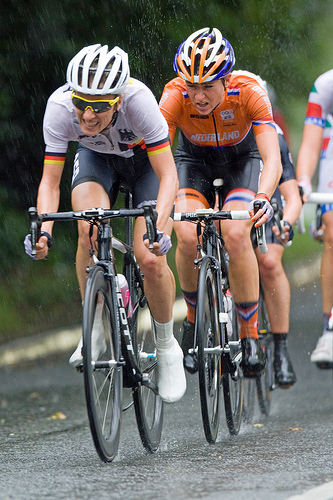

In [ ]:
random_sample = randint(0, len(dataset['test']))
print(dataset['test'][random_sample]['caption'])
embedding = 


dataset['test'][random_sample]['image']



In [ ]:
# Take a random sample and query
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=2
)